In [12]:
import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re

In [112]:
query = """with initial_dataset as (
  select
    event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVie','sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','sv__AAPageA','sv__ProPageA','sv_GoldPageA','sv__AAPageF','sv__ProPageF','sv__GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraph','PlayNextParagraphFromBut','sv__OnBoardingTutorialVie','in_app_purchase','PurchaseNormal')
),

onboarding as (
  select distinct
    'onboarding' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as onboarding_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as onboarding_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('sv__OnBoardingTutorialVi','sv__OnBoardingTutorialVie')
),

purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),

relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    purchases as pur on pur.user_pseudo_id = ini.user_pseudo_id
  left join
    onboarding as onb on onb.user_pseudo_id = ini.user_pseudo_id
  where
    ini.event_name not in ('in_app_purchase','PurchaseNormal','sv__OnBoardingTutorialVi','sv__OnBoardingTutorialVie')
  and
    ini.event_timestamp between onb.onboarding_timestamp and timestamp_add(onb.onboarding_timestamp, interval 7 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    purchases as rep
)

select
  user_pseudo_id,
  event_name,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2;"""

df = pandas_gbq.read_gbq(query, project_id= 'beelinguapp')

**checking the value counts for event_name and info**

In [113]:
df.event_name.value_counts()

sv__Libraries                108377
ClickOnWholeView              70833
sv__WelcomeCarouselDialog     64239
StartListening                62245
sv__StoryDetails              56846
StartNStory                   55447
LibraryClicked                24589
sv__NewPremiumAct             17012
sv__AAPageA                    9739
PremiumBarClickedMain          9543
sv__ProPageA                   7186
sv__AAPageF                    6303
StartBekids                    6277
PlayNextParagraphFromBut       6260
sv__GlossaryF                  5600
sv__ProPageF                   4873
PremiumBarClickedSD            4366
FabClickedPremium              2516
EnterFcMore                    2324
TryToBuyNewPAct                2044
sv__GoldPageF                  1948
in_app_purchase                1203
TryToBuyNewPF                   711
PlayPrevParagraph               186
Name: event_name, dtype: int64

In [114]:
df.event_name.nunique()

24

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530667 entries, 0 to 530666
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   user_pseudo_id         530667 non-null  object             
 1   event_name             530667 non-null  object             
 2   occurrences_count      530667 non-null  int64              
 3   first_event_timestamp  530667 non-null  datetime64[ns, UTC]
 4   last_event_timestamp   530667 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 16.2+ MB


**Purchases Based on Platforms**

In [119]:
df[df.event_name=='in_app_purchase']['user_pseudo_id'].nunique() == len(df[df.event_name=='in_app_purchase']['user_pseudo_id'])
# looking for whether there is user_pseudo_id

True

In [120]:
df['platform'] = df['user_pseudo_id'].apply(lambda x: 'Android' if re.findall('[a-z]',x) else 'IOS')
# creating platform column based on user_pseudo_id

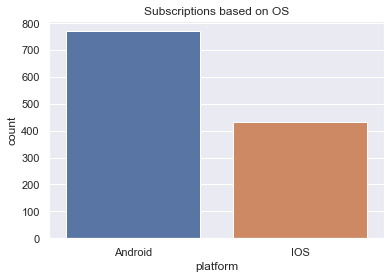

In [121]:
sns.set_theme(style="darkgrid")
sns.countplot(x='platform',data=df[df.event_name=='in_app_purchase'])
plt.title('Subscriptions based on OS')
plt.show()
# indicate in_app_purchases based on different OS

**Heat Map**

In [117]:
df_log = df.pivot_table(index=["user_pseudo_id"],columns=["event_name"],fill_value=0)
# getting the events_occurences aggregated in user_pseudo_level

In [122]:
df_log.columns = df_log.columns.droplevel()
# flattening the columns

In [123]:
df_log.reset_index(inplace=True)
# converting user_pseudo_id as a column

In [124]:
df_log['platform'] = df_log['user_pseudo_id'].apply(lambda x: 'Android' if re.findall('[a-z]',x) else 'IOS')
#adding platforms to df_log

In [125]:
df_log['in_app_purchase'].value_counts()
#there are 2 event occurences in_app_purchases

0    122954
1      1197
2         6
Name: in_app_purchase, dtype: int64

In [116]:
df[(df.event_name=='in_app_purchase') & (df.occurrences_count > 1)]['user_pseudo_id']
#users who purchased more than 1

2711     bfcd61286b149a8b98ab867c2a13df33
8434     f0f56bd5124953d82601d336f4a70a02
8646     9bdf2b9dc1e36c56dc20d1b8e05d2e92
9365     f768bb55076b14d51a52b709ff09a839
9821     e9aaf33848e3975412faa35cb045402f
10023    266edf372500183f0e8bd7c2a5e89c04
Name: user_pseudo_id, dtype: object

In [126]:
df[(df.event_name=='in_app_purchase') & (df.occurrences_count > 1)]

,user_pseudo_id,event_name,occurrences_count,first_event_timestamp,last_event_timestamp,platform
2711,bfcd61286b149a8b98ab867c2a13df33,in_app_purchase,2,2020-11-29 23:41:23.700000+00:00,2020-11-29 23:41:23.700000+00:00,Android
8434,f0f56bd5124953d82601d336f4a70a02,in_app_purchase,2,2020-12-07 14:31:13.085000+00:00,2020-12-07 14:31:13.085000+00:00,Android
8646,9bdf2b9dc1e36c56dc20d1b8e05d2e92,in_app_purchase,2,2020-11-26 14:48:33.986000+00:00,2020-11-26 14:48:33.986000+00:00,Android
9365,f768bb55076b14d51a52b709ff09a839,in_app_purchase,2,2020-11-13 02:37:20.622000+00:00,2020-11-13 02:37:20.622000+00:00,Android
9821,e9aaf33848e3975412faa35cb045402f,in_app_purchase,2,2020-11-01 17:31:38.489000+00:00,2020-11-01 17:31:38.489000+00:00,Android
10023,266edf372500183f0e8bd7c2a5e89c04,in_app_purchase,2,2020-11-10 15:32:55.119000+00:00,2020-11-10 15:32:55.119000+00:00,Android


In [127]:
df_log['in_app_purchase'] = np.where(df_log['in_app_purchase']>0,1,0)
#converting in_app_purchase as binary

In [128]:
df_log['in_app_purchase'].value_counts()
#checking the value counts again

0    122954
1      1203
Name: in_app_purchase, dtype: int64

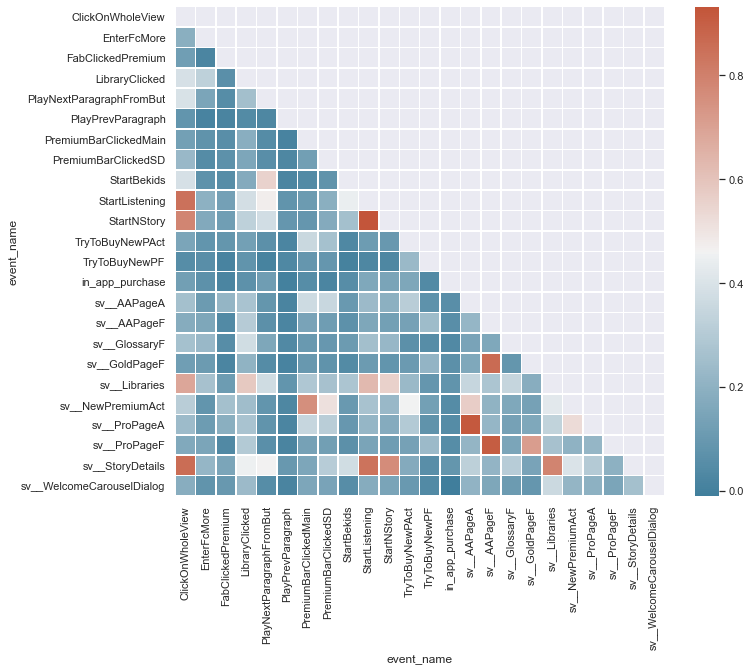

In [129]:
corr = df_log.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True)
plt.show()
#there is no really correlated events with in_app_purchase

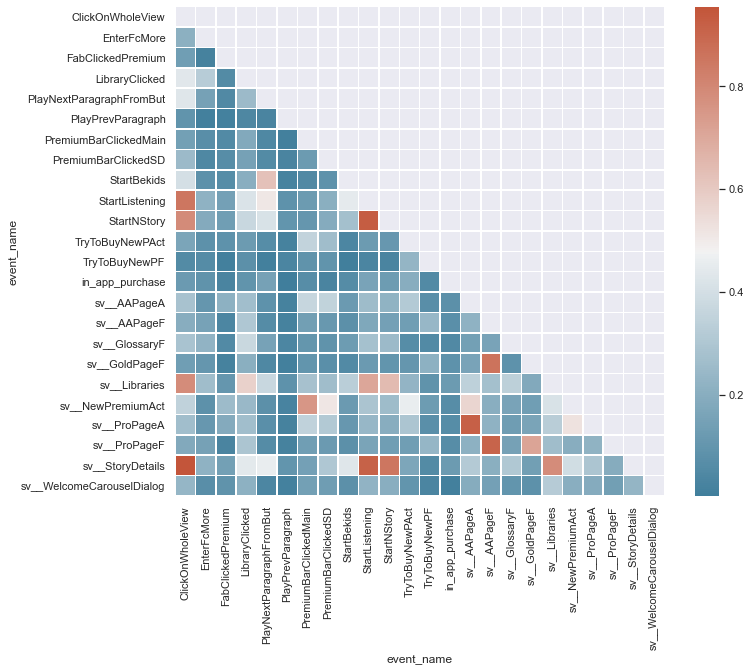

In [130]:
corr = df_log[df_log.platform=='Android'].corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True)
plt.show()
#only android also does not show any correlation

**Logistic Regression with All Events**

In [133]:
cols = ['ClickOnWholeView',
 'EnterFcMore',
 'FabClickedPremium',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'PremiumBarClickedMain',
 'PremiumBarClickedSD',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'TryToBuyNewPAct',
 'TryToBuyNewPF',
'sv__AAPageA',
 'sv__AAPageF',
 'sv__GlossaryF',
 'sv__GoldPageF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__ProPageA',
 'sv__ProPageF',
 'sv__StoryDetails',
 'sv__WelcomeCarouselDialog']

In [134]:
y = df_log['in_app_purchase']
X = df_log[cols]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()
#logistic regression for both platforms

Optimization terminated successfully.
         Current function value: 0.045652
         Iterations 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:               124157
Model:                          Logit   Df Residuals:                   124133
Method:                           MLE   Df Model:                           23
Date:                Sat, 12 Dec 2020   Pseudo R-squ.:                  0.1634
Time:                        10:36:23   Log-Likelihood:                -5668.1
converged:                       True   LL-Null:                       -6775.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.8216      0.040   -121.547      0.000      -4.899      -4.744
ClickOnWholeView              0.0023      0.009      0.268      0.788      -0.015       0.019
EnterFcMore                   0.3024      0.061      4.922      0.000       0.182       0.423
FabClickedPremium             0.7187      0.113      6.361      0.000       0.497       0.940
LibraryClicked                0.0555      0.014      4.003      0.000       0.028       0.083
PlayNextParagraphFromBut      0.0247      0.004      6.881      0.000       0.018       0.032
PlayPrevParagraph            -0.8534      0.486     -1.758      0.079      -1.805       0.098
PremiumBarClickedMain         0.0731      0.075      0.970      0.332      -0.075       0.221
PremiumBarClickedSD           0.2027      0.106      1.917      0.055      -0.005       0.410
StartBekids                  -0.2249      0.029     -7.767      0.000      -0.282      -0.168
StartListening                0.3315      0.018     18.152      0.000       0.296       0.367
StartNStory                  -0.1213      0.016     -7.566      0.000      -0.153      -0.090
TryToBuyNewPAct               1.3073      0.075     17.414      0.000       1.160       1.454
TryToBuyNewPF                -0.0042      0.030     -0.142      0.887      -0.063       0.055
sv__AAPageA                   0.3191      0.047      6.769      0.000       0.227       0.412
sv__AAPageF                  -0.1602      0.125     -1.286      0.199      -0.404       0.084
sv__GlossaryF                 0.0232      0.051      0.456      0.649      -0.077       0.123
sv__GoldPageF                 0.5642      0.142      3.973      0.000       0.286       0.843
sv__Libraries                -0.0057      0.006     -1.012      0.312      -0.017       0.005
sv__NewPremiumAct            -0.5502      0.071     -7.779      0.000      -0.689      -0.412
sv__ProPageA                 -0.2190      0.067     -3.251      0.001      -0.351      -0.087
sv__ProPageF                  0.1616      0.089      1.819      0.069      -0.013       0.336
sv__StoryDetails             -0.0794      0.006    -13.277      0.000      -0.091      -0.068
sv__WelcomeCarouselDialog    -0.4753      0.052     -9.171      0.000      -0.577      -0.374
=============================================================================================
"""

In [135]:
y = df_log[df_log.platform=='Android']['in_app_purchase']
X = df_log[df_log.platform=='Android'][cols]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()
#logistic regression only for Android

Optimization terminated successfully.
         Current function value: 0.034228
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:               108580
Model:                          Logit   Df Residuals:                   108556
Method:                           MLE   Df Model:                           23
Date:                Sat, 12 Dec 2020   Pseudo R-squ.:                  0.1882
Time:                        10:37:00   Log-Likelihood:                -3716.5
converged:                       True   LL-Null:                       -4577.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.1715      0.051   -101.850      0.000      -5.271      -5.072
ClickOnWholeView              0.0813      0.018      4.530      0.000       0.046       0.116
EnterFcMore                   0.2995      0.060      4.963      0.000       0.181       0.418
FabClickedPremium             0.7640      0.114      6.728      0.000       0.541       0.986
LibraryClicked                0.0470      0.014      3.275      0.001       0.019       0.075
PlayNextParagraphFromBut      0.0219      0.004      5.549      0.000       0.014       0.030
PlayPrevParagraph            -0.8426      0.493     -1.709      0.087      -1.809       0.124
PremiumBarClickedMain         0.0377      0.077      0.486      0.627      -0.114       0.189
PremiumBarClickedSD           0.1802      0.112      1.609      0.108      -0.039       0.400
StartBekids                  -0.1548      0.032     -4.906      0.000      -0.217      -0.093
StartListening                0.3673      0.025     14.876      0.000       0.319       0.416
StartNStory                  -0.1220      0.017     -7.121      0.000      -0.156      -0.088
TryToBuyNewPAct               1.3962      0.079     17.704      0.000       1.242       1.551
TryToBuyNewPF                 0.0016      0.030      0.052      0.959      -0.057       0.061
sv__AAPageA                   0.3621      0.048      7.539      0.000       0.268       0.456
sv__AAPageF                  -0.1817      0.126     -1.440      0.150      -0.429       0.066
sv__GlossaryF                 0.0950      0.049      1.949      0.051      -0.001       0.190
sv__GoldPageF                 0.6295      0.145      4.333      0.000       0.345       0.914
sv__Libraries                -0.0073      0.006     -1.190      0.234      -0.019       0.005
sv__NewPremiumAct            -0.5695      0.072     -7.907      0.000      -0.711      -0.428
sv__ProPageA                 -0.2991      0.070     -4.288      0.000      -0.436      -0.162
sv__ProPageF                  0.1567      0.088      1.782      0.075      -0.016       0.329
sv__StoryDetails             -0.1319      0.015     -8.962      0.000      -0.161      -0.103
sv__WelcomeCarouselDialog    -0.3334      0.053     -6.236      0.000      -0.438      -0.229
=============================================================================================
"""

**Query with 7 days and +30 minutes**

In [98]:
query="""with initial_dataset as (
  select
    case 
      when event_name like 'sv__OnBoardingTutorialVi%' then 'sv__OnBoardingTutorialView'
      else event_name
    end as event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','sv__AAPageA','sv__ProPageA','sv_GoldPageA','sv__AAPageF','sv__ProPageF','sv__GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraph','PlayNextParagraphFromBut','sv__OnBoardingTutorialVie','in_app_purchase','PurchaseNormal')
),   

premium_promo_shown as (
  select distinct
    user_pseudo_id,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_premium_promo_shown_timestamp
  from
    initial_dataset
  where
    event_name = 'sv__WelcomeCarouselDialog'
),

purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),

relevant_purchases as (
  select
    pu.event_name,
    pu.first_purchase_timestamp,
    pu.first_purchase_date,
    ps.first_premium_promo_shown_timestamp,
    pu.optional_label,
    pu.user_id,
    pu.user_pseudo_id,
    pu.ga_session_id,
    pu.user_history_event_number,
    pu.session_event_number,
    pu.platform,
    pu.device_language,
    pu.country
  from
    purchases as pu
  join
    premium_promo_shown as ps on ps.user_pseudo_id = pu.user_pseudo_id
  where
    pu.first_purchase_timestamp > timestamp_add(ps.first_premium_promo_shown_timestamp, interval 30 minute)
),

relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    premium_promo_shown as ps on ps.user_pseudo_id = ini.user_pseudo_id
  where
    event_name != 'in_app_purchase'
  and
    ini.event_timestamp between ps.first_premium_promo_shown_timestamp and timestamp_add(first_premium_promo_shown_timestamp, interval 7 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    relevant_purchases as rep
  where
    rep.first_purchase_timestamp between rep.first_premium_promo_shown_timestamp and timestamp_add(rep.first_premium_promo_shown_timestamp, interval 7 day)
)

select
  user_pseudo_id,
  event_name,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2;
"""
df2 = pandas_gbq.read_gbq(query, project_id= 'beelinguapp')

**Investigating Dataframe and Creating Pivot**

In [100]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408117 entries, 0 to 408116
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   user_pseudo_id         408117 non-null  object             
 1   event_name             408117 non-null  object             
 2   occurrences_count      408117 non-null  int64              
 3   first_event_timestamp  408117 non-null  datetime64[ns, UTC]
 4   last_event_timestamp   408117 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 12.5+ MB


In [101]:
df2["event_name"].value_counts() #why do we have still sv_WelcomeCarouselDialog here? although there is less purchase

sv__WelcomeCarouselDialog     64464
sv__Libraries                 60524
sv__StoryDetails              49357
ClickOnWholeView              48778
StartListening                43228
StartNStory                   37712
LibraryClicked                21321
sv__NewPremiumAct             17051
sv__AAPageA                    9859
PremiumBarClickedMain          9642
sv__ProPageA                   7294
sv__AAPageF                    6479
sv__ProPageF                   5025
sv__GlossaryF                  4911
StartBekids                    4364
PremiumBarClickedSD            4341
PlayNextParagraphFromBut       4120
FabClickedPremium              2437
TryToBuyNewPAct                2085
sv__GoldPageF                  2044
EnterFcMore                    1798
TryToBuyNewPF                   741
sv__OnBoardingTutorialView      273
PlayPrevParagraph               173
in_app_purchase                  96
Name: event_name, dtype: int64

In [102]:
df_log2 = df2.pivot_table(index=["user_pseudo_id"],columns=["event_name"],fill_value=0)

In [103]:
df_log2.columns = df_log2.columns.droplevel() #to get rid of the first column name of nested column

In [104]:
df_log2.reset_index(inplace=True)

**Logistic Regressions for +30 mins**

In [105]:
cols2 = ['ClickOnWholeView',
 'EnterFcMore',
 'FabClickedPremium',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'PremiumBarClickedMain',
 'PremiumBarClickedSD',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'TryToBuyNewPAct',
 'TryToBuyNewPF',
 'sv__AAPageA',
 'sv__AAPageF',
 'sv__GlossaryF',
 'sv__GoldPageF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__OnBoardingTutorialView',
 'sv__ProPageA',
 'sv__ProPageF',
 'sv__StoryDetails',
 'sv__WelcomeCarouselDialog']

In [106]:
y = df_log2['in_app_purchase']
X = df_log2[cols2]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.007341
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:                64464
Model:                          Logit   Df Residuals:                    64439
Method:                           MLE   Df Model:                           24
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                  0.3435
Time:                        21:52:10   Log-Likelihood:                -473.23
converged:                       True   LL-Null:                       -720.84
Covariance Type:            nonrobust   LLR p-value:                 1.632e-89
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -7.4580      0.334    -22.322      0.000      -8.113      -6.803
ClickOnWholeView              -0.0918      0.025     -3.658      0.000      -0.141      -0.043
EnterFcMore                    0.2950      0.165      1.783      0.075      -0.029       0.619
FabClickedPremium              0.7055      0.259      2.728      0.006       0.199       1.212
LibraryClicked                 0.1011      0.021      4.716      0.000       0.059       0.143
PlayNextParagraphFromBut       0.0222      0.006      3.649      0.000       0.010       0.034
PlayPrevParagraph             -0.0250      0.359     -0.070      0.945      -0.729       0.679
PremiumBarClickedMain          0.4250      0.117      3.633      0.000       0.196       0.654
PremiumBarClickedSD            0.8053      0.178      4.526      0.000       0.457       1.154
StartBekids                   -0.1243      0.052     -2.393      0.017      -0.226      -0.022
StartListening                 0.1140      0.040      2.857      0.004       0.036       0.192
StartNStory                   -0.0596      0.026     -2.282      0.022      -0.111      -0.008
TryToBuyNewPAct                0.5205      0.092      5.676      0.000       0.341       0.700
TryToBuyNewPF                  0.0698      0.032      2.197      0.028       0.008       0.132
sv__AAPageA                    0.0831      0.086      0.961      0.336      -0.086       0.252
sv__AAPageF                    0.1595      0.195      0.817      0.414      -0.223       0.542
sv__GlossaryF                 -0.3354      0.090     -3.730      0.000      -0.512      -0.159
sv__GoldPageF                 -0.0520      0.240     -0.216      0.829      -0.523       0.419
sv__Libraries                  0.0043      0.002      2.476      0.013       0.001       0.008
sv__NewPremiumAct             -0.5288      0.114     -4.655      0.000      -0.751      -0.306
sv__OnBoardingTutorialView    -0.0992      0.238     -0.416      0.677      -0.566       0.368
sv__ProPageA                   0.0417      0.107      0.389      0.698      -0.168       0.252
sv__ProPageF                   0.1618      0.134      1.208      0.227      -0.101       0.424
sv__StoryDetails               0.0432      0.020      2.167      0.030       0.004       0.082
sv__WelcomeCarouselDialog     -0.0554      0.284     -0.195      0.845      -0.612       0.501
==============================================================================================
"""

In [107]:
cols3 = [ 'ClickOnWholeView',
 'EnterFcMore',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'sv__GlossaryF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__OnBoardingTutorialView',
 'sv__StoryDetails',
]

In [108]:
y = df_log2['in_app_purchase']
X = df_log2[cols3]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.008373
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:                64464
Model:                          Logit   Df Residuals:                    64450
Method:                           MLE   Df Model:                           13
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                  0.2512
Time:                        21:53:48   Log-Likelihood:                -539.78
converged:                       True   LL-Null:                       -720.84
Covariance Type:            nonrobust   LLR p-value:                 2.172e-69
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -7.2158      0.138    -52.396      0.000      -7.486      -6.946
ClickOnWholeView              -0.0935      0.023     -4.088      0.000      -0.138      -0.049
EnterFcMore                    0.3843      0.195      1.971      0.049       0.002       0.767
LibraryClicked                 0.1502      0.026      5.719      0.000       0.099       0.202
PlayNextParagraphFromBut       0.0277      0.006      4.826      0.000       0.016       0.039
PlayPrevParagraph             -0.0101      0.327     -0.031      0.975      -0.651       0.631
StartBekids                   -0.1364      0.043     -3.200      0.001      -0.220      -0.053
StartListening                 0.1241      0.029      4.291      0.000       0.067       0.181
StartNStory                   -0.0733      0.021     -3.434      0.001      -0.115      -0.031
sv__GlossaryF                 -0.3767      0.097     -3.888      0.000      -0.567      -0.187
sv__Libraries                  0.0048      0.002      3.067      0.002       0.002       0.008
sv__NewPremiumAct              0.0260      0.009      2.907      0.004       0.008       0.044
sv__OnBoardingTutorialView    -0.0893      0.205     -0.435      0.664      -0.492       0.313
sv__StoryDetails               0.0413      0.015      2.673      0.008       0.011       0.072
==============================================================================================
"""

In [110]:
df2.to_csv('30days30minutes.csv')

In [111]:
df.to_csv('allevents.csv')